# GL benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an IPA kernel and collect results. The analysis phase will consist in comparing IPA summary with:


    
The benchmark we will be using is ***GLbenchmark***. You will need to **manually install** the app on the Android device in order to run this Notebook.


In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-07 16:34:25,212 INFO    : root         : Using LISA logging configuration:
2018-05-07 16:34:25,216 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/steven/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "cpu_capacity",
            "cpu_frequency",
            "thermal_power_devfreq_limit",
            "thermal_power_devfreq_get_power",
            "thermal_power_cpu_limit",
            "thermal_power_cpu_get_power",
            "thermal_zone_trip",
            "cdev_update",
            "thermal_temperature",
            "thermal_power_allocator_pid",
            "thermal_power_allocator",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'sysbench'],
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "power_virus",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "power_virus",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-05-07 16:34:28,495 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-05-07 16:34:28,497 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-05-07 16:34:28,499 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-05-07 16:34:28,501 INFO    : TestEnv      : External tools using:
2018-05-07 16:34:28,502 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/android-sdk
2018-05-07 16:34:28,503 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-05-07 16:34:28,504 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2018-05-07 16:34:28,505 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-05-07 16:34:28,506 INFO    : TestEnv      : Connection settings:
2018-05-07 16:34:28,507 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-05-07 16:34:30,415 INFO    : TestEnv      : Initializing target workdir:
2018-05-07 1

# Workload configuration

In [6]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())
duration=10

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        'stp_0': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_1': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_2': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_3': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_4': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration
        ).get(),
        'stp_5': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_6': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
        'stp_7': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=duration,          # duration    
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-05-07 16:34:34,557 INFO    : Workload     : Setup new workload simple
2018-05-07 16:34:34,660 INFO    : Workload     : Workload duration defined by longest task
2018-05-07 16:34:34,662 INFO    : Workload     : Default policy: SCHED_OTHER
2018-05-07 16:34:34,663 INFO    : Workload     : ------------------------
2018-05-07 16:34:34,664 INFO    : Workload     : task [stp_0], sched: using default policy
2018-05-07 16:34:34,666 INFO    : Workload     :  | loops count: 1
2018-05-07 16:34:34,667 INFO    : Workload     :  + phase_000001: batch 10.000000 [s]
2018-05-07 16:34:34,668 INFO    : Workload     : ------------------------
2018-05-07 16:34:34,669 INFO    : Workload     : task [stp_1], sched: using default policy
2018-05-07 16:34:34,671 INFO    : Workload     :  | loops count: 1
2018-05-07 16:34:34,672 INFO    : Workload     :  + phase_000001: batch 10.000000 [s]
2018-05-07 16:34:34,673 INFO    : Workload     : ------------------------
2018-05-07 16:34:34,674 INFO    : Workload     

In [7]:
class Sysbench(object):
    """
    Sysbench benchmark class.
    
    :param duration: maximum workload duration in seconds
    :type duration: int
    """
    sysbench_path = "/data/local/tmp/bin/sysbench"
    
    def __init__(self, target, duration):
        self.target = target
        self.duration = duration

    def run(self, cgroup, threads):
        """
        Run benchmark using the specified number of 'threads'
        to be executed under the specified 'cgroup'.
        
        :param cgroup: cgroup where to run the benchmark on
        :type cgroup: str
        
        :param threads: number of threads to spawn
        :type threads: int
        
        :returns: float - performance score
        """
        bench_out = self.target.cgroups.run_into(
            cgroup,
            "{} --test=cpu --num-threads={} --max-time={} run"
            .format(self.sysbench_path, threads, self.duration)
        )
        match = re.search(r'(total number of events:\s*)([\d.]*)', bench_out)
        return float(match.group(2))

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [8]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('schedutil')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    for cpu in target.list_online_cpus():
        tunables = target.cpufreq.get_governor_tunables(cpu)
        target.cpufreq.set_governor_tunables(
            cpu,
            'ondemand',
            **{'sampling_rate' : tunables['sampling_rate_min']}
        )

In [9]:
# CPUFreq configurations to test
confs = {
#     'performance' : {
#         'label' : 'prf',
#         'set' :  set_performance,
#     },
    #'powersave' : {
    #    'label' : 'pws',
    #    'set' :  set_powersave,
    #},
#      'interactive' : {
#          'label' : 'int',
#          'set' :  set_interactive,
#      },
    'sched' : {
       'label' : 'sch',
       'set' :  set_sched,
    },
    #'ondemand' : {
    #    'label' : 'odm',
    #    'set' :  set_ondemand,
    #}
}

# The set of results for each comparison test
results = {}

In [10]:
#Check if package si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages | grep -i {}'.format(pkgname))
        return output
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
pkgname=check_packages('glbench').split(':')[1]
print pkgname
target.adb_root(force=True)

com.glbenchmark.glbenchmark27



In [11]:
# Function that helps run a Antutu experiment
from android import Screen
from devlib.utils.android import adb_command
import re
from subprocess import Popen, PIPE
import time

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format(pkgname))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)
    target.clear_logcat()

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p   com.glbenchmark.glbenchmark27  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(10)
    
    # Flush entire log

    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)

    start_logline = r'ActivityManager: Displayed com.glbenchmark.glbenchmark27/net.kishonti.benchui.initialization.InitActivity'
    BENCHMARK_START_RE = re.compile(start_logline)
    end_logline = r'ActivityManager: *xyz'
    BENCHMARK_END_RE = re.compile(end_logline)
        
    logcat_cmd = 'adb -s {} shell logcat ActivityManager:* System.out:I *:S BENCH:*'\
                .format(target.adb_name)

    print logcat_cmd
        # Start the activity
    logcat = Popen(logcat_cmd, shell=True, stdout=PIPE)
    loop=0
    current=time.time()
    endtime = current + 60
    while True:

        # read next logcat line (up to max 1024 chars)
        message = logcat.stdout.readline(1024)

        loop=loop+1
        print message, loop
        print time.time()
        # Benchmark start trigger
        if BENCHMARK_START_RE.search(message):
            print("Benchmark started!")
            sleep(10)
            target.execute('input tap 180 1005')
            target.execute('input tap 958 571')
            rtapp.run(out_dir=te.res_dir, cgroup="")
            print("Benchmark ended!")
            break
        elif time.time() > endtime:
            break
        else:         
            continue
    
    sleep(1)
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
    adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))
    target.execute('am force-stop {}'.format(pkgname))

  

In [12]:
# Function that helps run PCMark for different governors
# trace_file = os.path.join(te.res_dir, 'trace.txt')

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    te.ftrace.start()

    benchmark_run(exp_dir)
    
    te.ftrace.stop()

    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run Antutu and collect scores

In [13]:
# Run the benchmark in all the configured governors
for governor in confs:
    test_dir = os.path.join(te.res_dir, governor)
    res = experiment(governor, test_dir)
    print governor

2018-05-07 16:34:38,744 INFO    : root         : ------------------------
2018-05-07 16:34:38,746 INFO    : root         : Run workload using sched governor
2018-05-07 16:34:43,087 INFO    : Screen       : Set brightness: 0%
2018-05-07 16:34:53,587 INFO    : Screen       : Force manual orientation
2018-05-07 16:34:53,589 INFO    : Screen       : Set orientation: PORTRAIT


adb -s 0123456789ABCDEF shell logcat ActivityManager:* System.out:I *:S BENCH:*
--------- beginning of main
1
1525682094.35
--------- beginning of system
2
1525682094.39
05-07 08:36:07.675  2214  2728 I ActivityManager: Force stopping com.glbenchmark.glbenchmark27 appid=10053 user=0: from pid 8010
3
1525682094.39
05-07 08:36:07.675  2214  2728 I ActivityManager: Killing 7657:com.glbenchmark.glbenchmark27/u0a53 (adj 900): stop com.glbenchmark.glbenchmark27
4
1525682094.39
05-07 08:36:07.675  2214  2728 D ActivityManager: cleanUpApplicationRecord -- 7657
5
1525682094.39
05-07 08:36:07.673  2214  2214 I ActivityManager: type=1400 audit(0.0:464): avc: denied { getpgid } for scontext=u:r:system_server:s0 tcontext=u:r:untrusted_app_25:s0:c512,c768 tclass=process permissive=1
6
1525682094.39
05-07 08:36:09.211  2214  2730 I ActivityManager: START u0 {act=android.intent.action.MAIN cat=[android.intent.category.LAUNCHER] flg=0x10200000 cmp=com.glbenchmark.glbenchmark27/net.kishonti.app.MainActi

2018-05-07 16:35:05,297 INFO    : Workload     : Workload execution START:
2018-05-07 16:35:05,299 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


Benchmark ended!
sched


After running the benchmark for the specified governors we can show and plot the scores:

In [14]:
te.ftrace.get_trace(os.path.join(te.res_dir, 'trace.dat'))


In [15]:
trappy.plotter.plot_trace(te.res_dir, execnames=['stp_0',   "stp_1", "stp_2",
                                             "stp_3", "stp_4", "stp_5", "stp_6","stp_7"
                                            ])

In [16]:
map_label = {"00000000,000000f0": "big", "00000000,0000000f": "LITTLE"}
actor_order = ["GPU", "big", "LITTLE"]


In [17]:
te.ftrace.report(os.path.join(te.res_dir, 'trace.dat'), os.path.join(te.res_dir, 'trace.txt'))
trace_file = os.path.join(te.res_dir, 'trace.txt')

In [18]:
te.ftrace.get_trace(os.path.join(te.res_dir, 'trace.dat'))

In [19]:
!tree {te.res_dir}

/home/steven/lisa/lisa-github/results/20180507_163428
├── output.log
├── rt-app-stp_0-0.log
├── rt-app-stp_0-3.log
├── rt-app-stp_1-1.log
├── rt-app-stp_1-2.log
├── rt-app-stp_2-1.log
├── rt-app-stp_2-2.log
├── rt-app-stp_3-0.log
├── rt-app-stp_3-3.log
├── rt-app-stp_4-4.log
├── rt-app-stp_4-7.log
├── rt-app-stp_5-5.log
├── rt-app-stp_5-6.log
├── rt-app-stp_6-5.log
├── rt-app-stp_6-6.log
├── rt-app-stp_7-4.log
├── rt-app-stp_7-7.log
├── sched
├── screen.png
├── simple_00.json
├── trace.dat
└── trace.txt

1 directory, 21 files


In [20]:
trappy.summary_plots(actor_order, map_label, path=os.path.join(te.res_dir, 'trace.dat'))

/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:201: UserWarning: Cached data is from another trace, invalidating cache.
  warnings.warn(warnstr)


AttributeError: 'NoneType' object has no attribute 'iteritems'

In [18]:
benchmark_run(te.res_dir)

2017-11-28 10:08:08,696 INFO    : Screen       : Set brightness: 0%
2017-11-28 10:08:19,224 INFO    : Screen       : Force manual orientation
2017-11-28 10:08:19,226 INFO    : Screen       : Set orientation: PORTRAIT


NameError: global name 're' is not defined

In [39]:
adb_command(target.adb_name, 'shell screencap -p /data/local/tmp/screen.png')
adb_command(target.adb_name, 'pull /data/local/tmp/screen.png {}'.format(te.res_dir))

'[ 20%] /data/local/tmp/screen.png\n[ 41%] /data/local/tmp/screen.png\n[ 61%] /data/local/tmp/screen.png\n[ 82%] /data/local/tmp/screen.png\n[100%] /data/local/tmp/screen.png\n/data/local/tmp/screen.png: 1 file pulled. 5.4 MB/s (318902 bytes in 0.057s)\n'

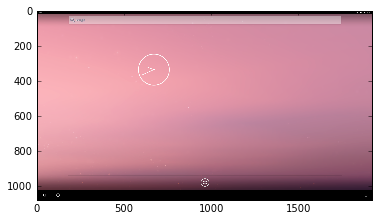

In [43]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img=mpimg.imread( os.path.join(te.res_dir, 'screen.png'))
imgplot = plt.imshow(img)

